# Introduction to NetworkModelGrid
This tutorial provides a basic introduction to the ``NetworkModelGrid`` grid class in Landlab. 

In its current form it is intended to highlight current capabilities and spark discussion on what sort of capabilities this model grid class should have. 

In [1]:
# Start by importing necessary modules
from landlab.grid.network import NetworkModelGrid
import numpy as np

In [2]:
# define a grid, right now this is done by passing three datastructures:
# grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

y_of_node = (0, 1, 2, 2)
x_of_node = (0, 0, -1, 1)
nodes_at_link = ((1, 0), (2, 1), (3, 1))
grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)


print(grid.x_of_node)
#array([ 0.,  0., -1.,  1.])
print(grid.y_of_node)
#array([ 0.,  1.,  2.,  2.])
print(grid.nodes_at_link)
#array([[0, 1],
#       [2, 1],
#       [1, 3]])

# we can store simple arrays at links and at nodes (complex things lower in the notebook)
grid.at_node['z'] = [1,2,3,4]
grid.at_link['z'] = [10,20,30]

[ 0.  0. -1.  1.]
[ 0.  1.  2.  2.]
[[0 1]
 [2 1]
 [1 3]]



## DISCUSSION ITEM:

What are other ways you'd like to be able to import a Network?
Shapefile? Derived from a Raster? etc?

In [3]:
# methods that work for with only links and nodes on other landlab grids
# work here too. 

from landlab.grid.gradients import calc_grad_at_link
calc_grad_at_link(grid, 'z')
#array([ 1.        , -0.70710678,  1.41421356])

array([ 1.        , -0.70710678,  1.41421356])


## DISCUSSION ITEM:

Are there any methods that you'd expect to want that are not presently supported?

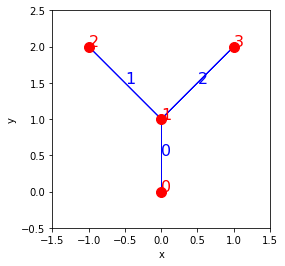

In [4]:
# there is a nice plotting function for simple graphs. 

from landlab.plot import graph
graph.plot_graph(grid, at='node,link')

In [5]:
# and we can save to the Ugrid format
grid.to_netcdf('network.nc')

In [6]:
# we think this should work, but its not working on Katy's computer
!ncdump -h network.nc

*** ncdump: ncopen failed on network.nc


In [7]:
# Though a netcdf is created
!ls

Example_Usage_of_Network_Model_Grid.ipynb
network.nc


In [8]:
# store values at links and nodes
z_link = grid.add_zeros('topographic__elevation', at='link')

print(z_link)

# store values at links and nodes
z_node = grid.add_ones('topographic__elevation', at='node')

print(z_node)

[ 0.  0.  0.]
[ 1.  1.  1.  1.]


In [9]:
# like on a raster model grid, links have directions. 
grid.link_dirs_at_node

array([[-1,  0,  0],
       [-1,  1,  1],
       [-1,  0,  0],
       [ 1,  0,  0]])

One might want to store more complicated things at grids and nodes. Two things that have come up in discussions are:

1) Storing ragged arrays at links and nodes

2) Storing profiles (e.g. long channel profiles) on links. 

The next two cells give an example of such datastructures. 

These two examples work, though we don't know the efficiency in model usage of these implementations. 

These work because we can create a numpy object array of length number-of-links or number-of-nodes and store this array at links or nodes. 

Here we've stored numpy arrays and dictionaries, but it could be lists, sets, etc. 

In [10]:
# store ragged arrays at links and nodes
sediment_id = [np.array([0]),
               np.array([3,5]),
               np.array([2,1,4,6])]

grid.at_link['sediment_id']=sediment_id


water_id = [np.array([0]),
            np.array([3,5]),
            np.array([2,1,4,6]),
            np.array([8,9,10,11])]

grid.at_node['water_id']=water_id




In [11]:
# store profiles at links and nodes
profiles_at_link = [{'x': np.arange(10), 'y': np.random.randn(10)},
                    {'x': np.arange(30), 'y': np.random.randn(30)},
                    {'x': np.arange(40), 'y': np.random.randn(40)}]

grid.at_link['sediment_id']=profiles_at_link

In [12]:
print(grid.at_link['sediment_id'])


[ {'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'y': array([-0.91574797, -1.10980645,  1.61805458,  1.09715119,  0.46876906,
        0.96054001, -0.69796807, -0.1189281 , -1.23878835, -0.86334011])}
 {'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'y': array([-0.14251943, -0.46558603,  1.55137365, -0.27582223,  1.08198828,
       -0.56779053, -0.10080479,  0.79834027,  0.98227584,  0.50867264,
        1.48604841, -0.76041564,  2.2534034 , -2.01132642,  0.43052589,
        0.27050367,  0.35121118,  0.12402067,  1.33312791,  0.52497766,
       -0.24639183, -0.41127502,  2.2489135 , -1.01967039, -0.97418952,
       -1.45399536, -0.19934094,  0.75755795, -1.6857706 , -0.13267049])}
 {'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), 'y': array([ 0.73564767,  0.96

#Discussion
What other things need to be stored on the Grid?
